<a href="https://colab.research.google.com/github/iwantedtoentermyname/pytorch_exercises/blob/main/Pytorch_computer_vision_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.



In [ ]:
# Installing tqdm
!pip install tqdm

In [ ]:
# Installing torchmetrics
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 4.8 MB/s eta 0:00:00


In [ ]:
# Check for GPU
!nvidia-smi

Mon Jan 29 20:10:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# Importing libraries to work with helper functions
from pathlib import Path
import requests

# If statement to check if helper functions have already been installed
if Path("helper_functions.py").is_file():
  print("HF.py exist skipping download")
else:
  print("🤖Downloading helper_functions.py")
  requests = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(requests.content)

🤖Downloading helper_functions.py


In [ ]:
# Importing helper functions
from helper_functions import accuracy_fn

In [ ]:
# Importing all needed libraries
import torchvision
import matplotlib.pyplot as plt
import random
from torch.utils.data import DataLoader
from torch import nn
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torchvision import datasets

In [ ]:
# Import torch
import torch

# Checking torch version
print(torch.__version__)

# Seting up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

2.1.0+cu121


# 1. Preparing and visualizing the data

## 1.1. Loading training and testing datasets from FashionMNIST datasets

In [ ]:
# Loading dataset from MNIST and setting it as a training data
train_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 99025862.38it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 36257316.32it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 30838582.71it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 20707096.49it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
# Loading dataset from MNIST and setting it as a testing data
test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [ ]:
# Displaying the data
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

## 1.2. Visualizing images from loaded dataset

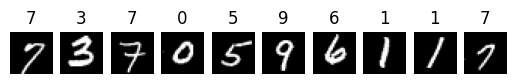

In [ ]:
# Visualizing the data
num_plots = 10
for i in range(num_plots):
  random_number = random.randint(1,len(train_data)-1)
  image, label = train_data[random_number]
  plt.subplot(1,num_plots, i+1)
  plt.imshow(image.squeeze(0), cmap="gray")
  plt.title(label)
  plt.axis(False)

## 1.3 Turning training/testing datasets into trainin/testing dataloaders

In [ ]:
# Turning training data into training dataloader
train_dataloader = DataLoader(
    train_data,
    batch_size=32,
    shuffle=True
)

In [ ]:
# Turning testing data into testing dataloader
test_dataloader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False
)

In [ ]:
# Displaying classes of train data
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [ ]:
# displaying images shape
one_image = train_data[0]
image, label = one_image
image.shape

torch.Size([1, 28, 28])

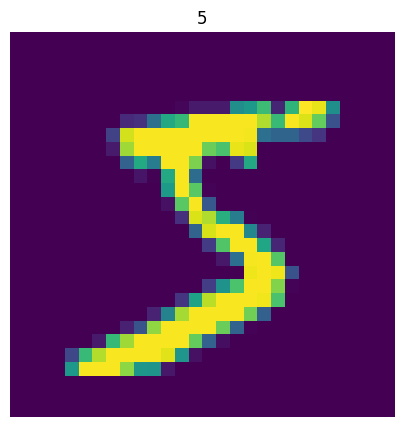

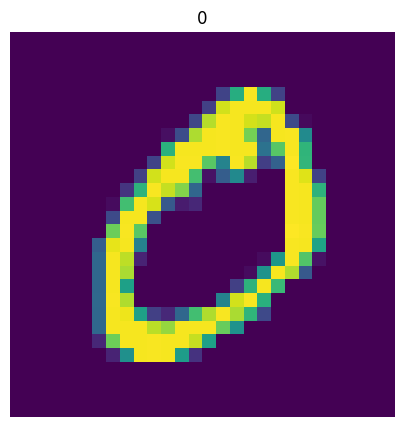

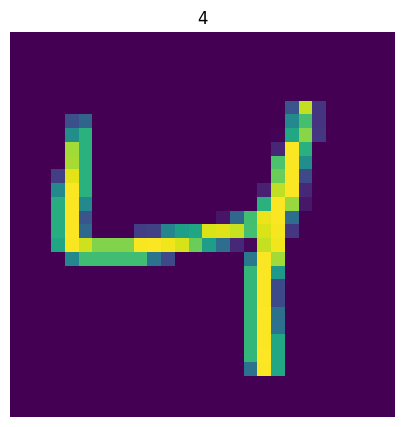

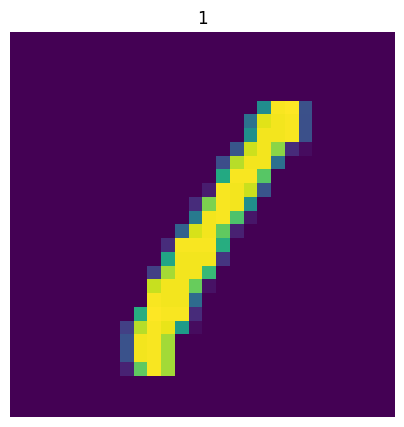

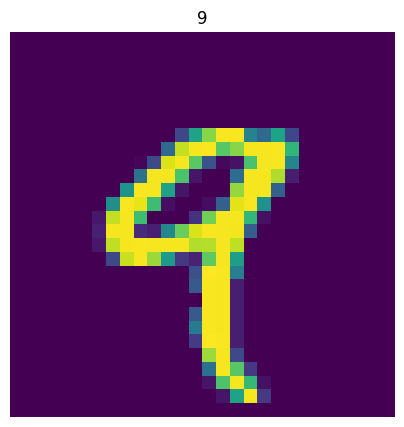

In [ ]:
# Visualizing the data of MNIST
for i in range(5):
  img = train_data[i][0]
  label = train_data[i][1]
  plt.figure(figsize=(5,5))
  plt.imshow(img.squeeze(0))
  plt.title(label)
  plt.axis(False)

In [ ]:
### Defining functions for training and testing
# Defining training function
def train_step(model: nn.Module,
               loss_fn: nn.Module,
               optimizer: torch.optim,
               data_loader: torch.utils.data,
               accuracy_fn: accuracy_fn,
               device: device):

  # Initliazing train loss and accuracy
  train_loss, train_acc = 0, 0

  # Setting the model into ,,training mode,,
  model.train()

  # loop for trainig the model
  for batch, (X, y) in enumerate(data_loader):

    # Setting X, y data into right device with device-agnostic code
    X, y = X.to(device), y.to(device)

    # Making predictions with the model
    y_pred = model(X)

    # Setting predicted labels
    pred_label = torch.softmax(y_pred,dim=0).argmax(1)

    # Using the loss function on predicted data
    loss = loss_fn(y_pred, y)

    # Adding loss value to train_loss variable
    train_loss += loss

    # Adding accuracy
    train_acc += accuracy_fn(y, pred_label)

    # Zeroing the gradient
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Taking a step with the optimizer
    optimizer.step()

  # Calcilating overall loss
  train_loss /= len(train_dataloader)
  # Calcilating overall accuracy
  train_acc /= len(train_dataloader)

  # Providing info during training loop
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc}%")

# Defining testing function
def test_step(model: nn.Module,
              loss_fn: nn.Module,
              accuracy_fn: accuracy_fn,
              data_loader: torch.utils.data,
              device: device):

  # Initliazing test loss and accuracy
  test_loss, test_acc = 0, 0

  # Setting the model into ,,evaluate mode,,
  model.eval()

  # Testing loop
  with torch.inference_mode():
    for X, y in data_loader:

      # Setting X, y data into right device with device-agnostic code
      X, y = X.to(device), y.to(device)

      # Making predictions with the model
      test_pred = model(X)
      # Setting predicted label
      test_label = torch.softmax(test_pred, dim=0).argmax(1)

      # Adding loss value to test_loss variable
      test_loss += loss_fn(test_pred, y)
      # Adding accuracy value to test_acc variable
      test_acc += accuracy_fn(y, test_label)

    # Calculating overall loss and accuracy
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    # Printing info
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")


# 3. Recreating TinyVGG capable of fitting the MNIST data, making training loops and visualizing the data

In [ ]:
# MNIST model architecture
class MNISTSupermodel(nn.Module):
  def __init__(self, input_shape:int,
               hidden_units:int,
               output_shape:int):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.classifier_block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape))

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier_block(x)
    #print(x.shape)
    return x

In [ ]:
# Setting the manual seed for repeatable results
torch.manual_seed(42)

# Initializing the model
model_0_cpu = MNISTSupermodel(input_shape=1, hidden_units=10, output_shape=len(class_names)).to("cpu")

In [ ]:
# "Trick" to find out what shape is the output of the model
# in order to set up the right value in ,,self.classifier_block,, of MNISTSupermodel
# Since we got RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x490 and 10x10)
# we have to multiply ,,hidden_units,, of nn.Linear positioned in self.classifier
# by 7*7 to match 1x490
dummy = model_0_cpu(image.unsqueeze(0))
pred_labels = torch.softmax(dummy, dim=0).argmax(1)
pred_labels

torch.Size([1, 10, 14, 14])
torch.Size([1, 10, 7, 7])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x490 and 10x10)

In [ ]:
# Now it's working
dummy = model_0_cpu(image.unsqueeze(0))
pred_labels = torch.softmax(dummy, dim=0).argmax(1)
pred_labels

tensor([0])

In [ ]:
# Setting the model
model_0_gpu = MNISTSupermodel(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

##CPU trained model

In [ ]:
# Setting the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0_cpu.parameters(), lr=0.1)

In [ ]:
### Making training and testing loop
### without using train_step and test_step functios

# Setting manual seed
torch.manual_seed(42)

# Setting the number of epochs
epochs = 5

# Timestamp in start
train_time_model_0_cpu_start = timer()

# Training/testing loops... note: tqdm for visual loading bar
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-----")

  # Initializin train/test loss for further calculations
  train_loss, train_acc = 0, 0

  # train loop
  for batch, (X, y) in enumerate(train_dataloader):
    # Transfering data into CPU
    X, y = X.to("cpu"), y.to("cpu")

    # Setting the model into train mode
    model_0_cpu.train()

    # Making prediction with the model
    y_pred = model_0_cpu(X)
    # Extracting predicted classes from the model's output using argmax(1)
    pred_label = y_pred.argmax(1)

    # Calculating the loss
    loss = loss_fn(y_pred, y)
    # Adding loss value into train_loss variable
    train_loss += loss
    # Calculating and adding accuracy value to train_accuracy variable
    train_acc += accuracy_fn(y, pred_label)

    # Zeroing the gradient
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()
    # Taking a step with the optimizer
    optimizer.step()

    # If statement to provide info during training at certain epoch
    if batch % 400 == 0:
      print(f"Loked at {batch*len(X)} / {len(train_dataloader.dataset)} samples.")

  # Calculating overall train loss and accuracy
  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)

  # Initializing test loss and accuracy
  test_loss, test_acc = 0, 0

  # Setting model into eval mode
  model_0_cpu.eval()

  ## Test loop
  with torch.inference_mode():
    for X, y in test_dataloader:
      # Making predictions with test data
      test_pred = model_0_cpu(X)
      # Editing data for accuracy calculation
      test_label = test_pred.argmax(1)

      # Calculating and addding loss and accuracy
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y, test_label)

    # Calculating overall loss and accuracy
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)

  # Printing info for every epoch
  print(f"\nTrain Loss: {train_loss:.4f} | Train acc: {train_acc:.4f}\nTest Loss: {test_loss:.4f} test acc: {test_acc:.4f}")

# Timestamp afer ending the loop
train_time_model_0_cpu_end = timer()

# Calculation for overall time needed for taining and testing the model
total_time_model_0_cpu = train_time_model_0_cpu_start - train_time_model_0_cpu_end

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----
Loked at 0 / 60000 samples.
Loked at 12800 / 60000 samples.
Loked at 25600 / 60000 samples.
Loked at 38400 / 60000 samples.
Loked at 51200 / 60000 samples.

Train Loss: 0.3356 | Train acc: 88.7417
Test Loss: 0.0736 test acc: 97.7137
Epoch: 1
-----
Loked at 0 / 60000 samples.
Loked at 12800 / 60000 samples.
Loked at 25600 / 60000 samples.
Loked at 38400 / 60000 samples.
Loked at 51200 / 60000 samples.

Train Loss: 0.0822 | Train acc: 97.4367
Test Loss: 0.0660 test acc: 97.9533
Epoch: 2
-----
Loked at 0 / 60000 samples.
Loked at 12800 / 60000 samples.
Loked at 25600 / 60000 samples.
Loked at 38400 / 60000 samples.
Loked at 51200 / 60000 samples.

Train Loss: 0.0644 | Train acc: 97.9700
Test Loss: 0.0595 test acc: 98.0431
Epoch: 3
-----
Loked at 0 / 60000 samples.
Loked at 12800 / 60000 samples.
Loked at 25600 / 60000 samples.
Loked at 38400 / 60000 samples.
Loked at 51200 / 60000 samples.

Train Loss: 0.0559 | Train acc: 98.2217
Test Loss: 0.0614 test acc: 97.9233
Epoch: 4

In [ ]:
total_time_model_0_cpu = train_time_model_0_cpu_end - train_time_model_0_cpu_start
total_time_model_0_cpu

236.98563209200006

In [ ]:
### Function for evaluating the model after training
def evalueate_model_CPU(model: nn.Module,
                    loss_fn: nn.Module,
                    optimizer: torch.optim,
                    data_loader: torch.utils.data,
                    accuracy_fn):

  # Initializing loss and accuracy
  loss, acc = 0, 0

  # Setting the model into evaluation mode
  model.eval()

  # Evaluating loop
  with torch.inference_mode():
    for X, y in data_loader:
      # Transfering data into CPU
      X, y = X.to("cpu"), y.to("cpu")

      # Getting model predictions
      y_logits = model(X)
      pred_labels = torch.softmax(y_logits, dim=0).argmax(1)

      # Getting loss and accuracy for further overall calculations
      loss += loss_fn(y_logits, y)
      acc += accuracy_fn(y, pred_labels)

    # Calculating overall loss and accuracy
    loss /= len(data_loader)
    acc /= len(data_loader)

  # Returning evaluation results as a dictionary
  return {"model_name": model.__class__.__name__,
          "model_loss": loss.item(),
          "model_acc": acc}

# Evaluating the trained model on CPU
model_0_cpu_result = evalueate_model_CPU(model_0_cpu,
                    loss_fn,
                    optimizer,
                    test_dataloader,
                    accuracy_fn)



In [ ]:
# Displaying model's overall performance which, according to the results ,is good
model_0_cpu_result

{'model_name': 'MNISTSupermodel',
 'model_loss': 0.0468423031270504,
 'model_acc': 92.68170926517571}

In [ ]:
### Function for making predictions with trained model
def make_predictions_cpu(model: nn.Module,
                        data:list):

  # Initializin predictions' probabilities
  pred_probs = []

  # Setting model into evaluation mode
  model.eval()

  # Prediction loop
  with torch.inference_mode():
    for sample in data:
      # Unsqueezing the sample to match model's input dimensions
      sample = torch.unsqueeze(sample, dim=1)

      # Making predictions
      pred_logits = model(sample)
      # Making predictions' probabilities
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      # Appending probabilities into pred_probs list
      pred_probs.append(pred_prob)

  # Returning Predictions probabilities as a stacked tensors
  return torch.stack(pred_probs)


In [ ]:
### Generating random 9 test samples from test_data
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

In [ ]:
# Making predictions on the CPU for the selected test samples using the trained model
pred_probs_model_0_cpu = make_predictions_cpu(model_0_cpu,
                                            test_samples)

In [ ]:
# Dummy test with model prediction on a single sample
dummy_test = model_0_cpu(torch.unsqueeze(test_samples[1],dim=1))

In [ ]:
# Importing random
import random
result = []

# Setting the model into evaluation mode
model_0_cpu.eval()
with torch.inference_mode():
  # Unsqueezing the first test sample to match the model's input dimensions
  inpt = torch.unsqueeze(test_samples[0],0)

  # Dummy prediction on the first test sample
  dummy_first = model_0_cpu(inpt)
  dummy_prob = torch.softmax(dummy_first.unsqueeze(0), dim=0)

  # Appending the dummy probability to the result list
  result.append(dummy_prob)


In [ ]:
# Displaying the results
result

[tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])]

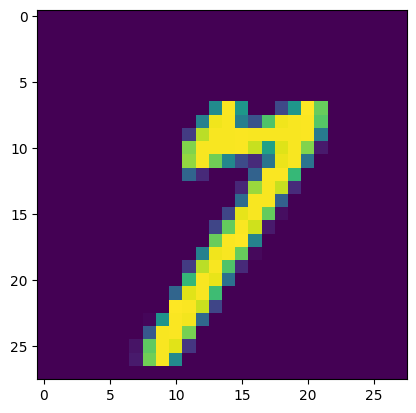

In [ ]:
# Visualizing first value from test_samples list
plt.imshow(test_samples[0].squeeze())

In [ ]:
result = torch.unsqueeze(test_samples[0],0)
result.ndim

4

In [ ]:
test_samples[0].ndim

3

(-0.5, 27.5, 27.5, -0.5)

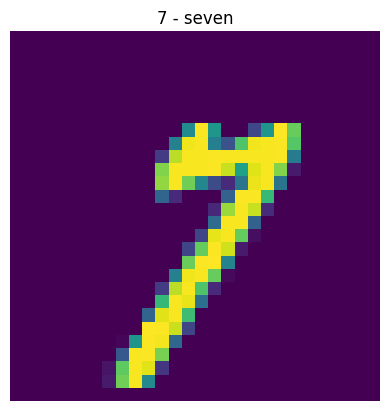

In [ ]:
# Visualizing first value from test_samples list
plt.imshow(test_samples[0].squeeze())

plt.title(class_names[test_labels[0]])
plt.axis(False)

In [ ]:
# Displaying test labels
test_labels[:]

[7, 1, 4, 7, 9, 5, 4, 3, 3]

In [ ]:
print(pred_probs_model_0_cpu[0])

tensor([1.6001e-08, 3.1706e-05, 1.5194e-06, 3.4429e-04, 8.1228e-07, 2.6206e-08,
        2.7977e-12, 9.9784e-01, 1.2284e-07, 1.7819e-03])


##Plotting a confusion matrix comparing model's predictions to the truth labels.

In [ ]:
# Making predictions with trained model on the test dataset
y_preds = []

# Setting the model into evaluation mode
model_0_cpu.eval()

# Inference loop with torch.inference_mode(), tqdm for progress loading bar
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making preds"):
    # Getting model predictions
    y_logit = model_0_cpu(X)

    # Converting logits to probabilities and getting the predicted class
    y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)

    # Appending the predictions to the y_preds list
    y_preds.append(y_pred)

# Concatenating the predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making preds:   0%|          | 0/313 [00:00<?, ?it/s]

In [ ]:
len(y_pred_tensor)

10000

In [ ]:
len(class_names)

10

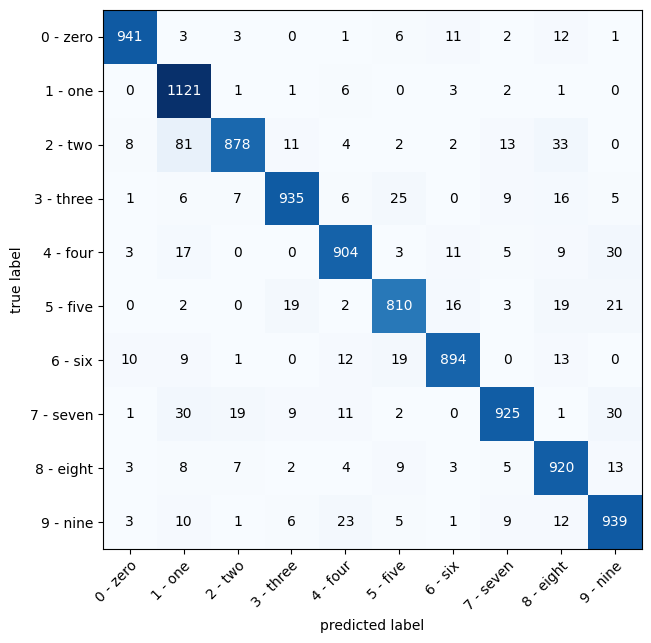

In [ ]:
# Making confusion matrix with trained model
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

# 4. Making prediction and visualisations on FashionMNIST dataset


In [ ]:
# Preparing testing and training datasets from FashionMNIST dataset
fashion_test_data = datasets.FashionMNIST(root="data_f",
                                          train=False,
                                          transform=torchvision.transforms.ToTensor(),
                                          download=True)

fashion_train_data = datasets.FashionMNIST(root="data_f",
                                           train=True,
                                           transform=torchvision.transforms.ToTensor(),
                                           download=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15880485.59it/s]


Extracting data_f/FashionMNIST/raw/train-images-idx3-ubyte.gz to data_f/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265494.73it/s]


Extracting data_f/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data_f/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4914852.30it/s]


Extracting data_f/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data_f/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7961754.05it/s]

Extracting data_f/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data_f/FashionMNIST/raw



In [ ]:
# Turning datasets into dataloaders
fashion_test_dataloader = DataLoader(fashion_test_data,
                                     batch_size=32,
                                     shuffle=False)

fashion_train_dataloader = DataLoader(fashion_train_data,
                                      batch_size=32,
                                      shuffle=True)

In [ ]:
# Getting class names of the dataset
fashion_class_names = fashion_train_data.classes
fashion_class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

(-0.5, 27.5, 27.5, -0.5)

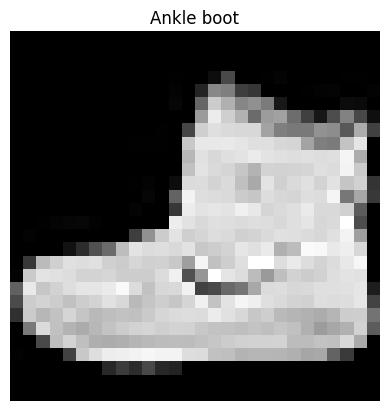

In [ ]:
# Visualizing the first image from the dataset
image, label = fashion_train_data[0]
plt.imshow(image.squeeze(0), cmap="gray")
plt.title(fashion_class_names[label])
plt.axis(False)

In [ ]:
# Displaying images shape
image.shape

torch.Size([1, 28, 28])

In [ ]:
# FashionMNIST architecture for FashionMNIST dataset
class FashionMNISTmodel(nn.Module):
  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape:int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2))

    self.classifier_block = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,
                  out_features=output_shape))

  def forward(self, x: torch.Tensor):

    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier_block(x)
    #print(x.shape)
    return x

In [ ]:
# Creating FashionMNIST model on CPU device
torch.manual_seed(42)
model_0_fashion_cpu = FashionMNISTmodel(input_shape=1,
                                    hidden_units=10,
                                    output_shape=len(fashion_class_names)).to("cpu")

In [ ]:
# Making dummy tensor to find out final shape from self.classifier_block
test_tensor = torch.randn(size=([1, 28, 28]))
test_tensor.shape

torch.Size([1, 28, 28])

In [ ]:
# Passing dummy tensor for final FashionMNIST modification
model_0_fashion_cpu(test_tensor.unsqueeze(0))

torch.Size([1, 10, 14, 14])
torch.Size([1, 10, 7, 7])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x490 and 10x10)

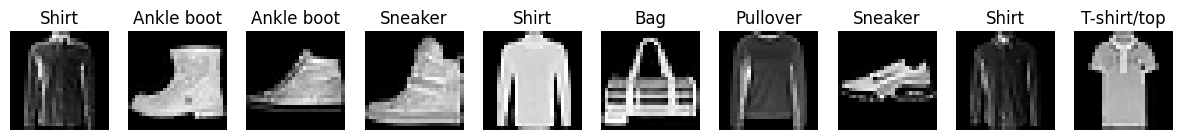

In [ ]:
# Ploting random images from training data
num_plots = 10
plt.figure(figsize=(15,12))
for i in range(num_plots):

  random_number = random.randint(1,len(fashion_train_data)-1)
  image, label = fashion_train_data[random_number]
  plt.subplot(1,num_plots, i+1)
  plt.imshow(image.squeeze(0), cmap="gray")
  plt.title(fashion_class_names[label])
  plt.axis(False)

In [ ]:
# Setting up loss function and optimizer

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model_0_fashion_cpu.parameters(), lr=0.1)

In [ ]:
### Training and testing loop for FashionMNIST model on CPU device

# Setting random seed
torch.manual_seed(42)

# Setting number of epochs
epochs = 3

# Time stamping start of the loop
time_model_0_fashion_cpu_start = timer()

# Training and testng loop
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n--------")

  # Initializin train/test loss for further calculations
  train_loss, train_acc = 0, 0

  # train loop
  for batch, (X, y) in enumerate(fashion_train_dataloader):
    # Transfering data into CPU
    X, y = X.to("cpu"), y.to("cpu")

     # Setting the model into train mode
    model_0_fashion_cpu.train()

    # Making prediction with the model
    y_pred = model_0_fashion_cpu(X)

    # Calculating the loss
    loss = loss_fn(y_pred, y)
    # Adding loss value into train_loss variable
    train_loss += loss
    # Calculating and adding accuracy value to train_accuracy variable
    train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

    # Zeroing the gradient
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Taking a step with the optimizer
    optimizer.step()
    # If statement to provide info during training at certain epoch
    if batch % 400 == 0:
      print(f"Looked at {batch*len(X)} / {len(fashion_train_dataloader.dataset)} samples.")

  # Calculating overall train loss and accuracy
  train_loss /= len(fashion_train_dataloader)
  train_acc /= len(fashion_train_dataloader)

  ### Test
  # Initializing test loss and accuracy
  test_loss, test_acc = 0, 0

  # Setting model into eval mode
  model_0_fashion_cpu.eval()
  with torch.inference_mode():
    for X, y in fashion_test_dataloader:
      # Making predictions with test data
      test_pred = model_0_fashion_cpu(X)

      # Calculating and addding loss and accuracy
      test_loss += loss_fn(test_pred, y)
      test_acc += accuracy_fn(y, test_pred.argmax(1))

    # Calculating overall loss and accuracy
    test_loss /= len(fashion_train_dataloader)
    test_acc /= len(fashion_test_dataloader)

  # Printing info for every epoch
  print(f"\nTrain loss: {train_loss:.4f}, train acc: {train_acc:.4f}\nTest loss: {test_loss:.4f} test acc: {test_acc:.4f}")

# Timestamp afer ending the loop
time_model_0_fashion_cpu_end = timer()

# Calculation for overall time needed for taining and testing the model
total_time_model_0_fashion_cpu = time_model_0_fashion_cpu_end - time_model_0_fashion_cpu_start

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
--------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.5952, train acc: 78.3750
Test loss: 0.0659 test acc: 85.9924
Epoch: 1
--------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.3654, train acc: 86.9017
Test loss: 0.0588 test acc: 86.9109
Epoch: 2
--------
Looked at 0 / 60000 samples.
Looked at 12800 / 60000 samples.
Looked at 25600 / 60000 samples.
Looked at 38400 / 60000 samples.
Looked at 51200 / 60000 samples.

Train loss: 0.3259, train acc: 88.1283
Test loss: 0.0546 test acc: 88.0691


In [ ]:
# Total time needed to train the model on CPU device
total_time_model_0_fashion_cpu

140.78845237399992

##  FashionMNIST model trained on GPU

In [ ]:
# Setting the model to device i.e. GPU
model_1_MNIST_GPU = MNISTSupermodel(input_shape=1,
                                    hidden_units=10,
                                    output_shape=len(class_names)).to(device)

In [ ]:
# Setting loss function and optimizer
loss_fn_gpu = nn.CrossEntropyLoss()

optimizer_gpu = torch.optim.SGD(model_1_MNIST_GPU.parameters(), lr=0.1)

In [ ]:
### Training and testing loop for MNIST GPU
# with train and test step functions

# Setting manual seed
torch.manual_seed(42)

# Setting number of epochs
epochs = 3

# Timestamping start of the loop
train_time_start_gpu = timer()

# Training and testing loop using train/test step functions
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")

  # Calling the training step function with necessary inputs
  train_step(model=model_1_MNIST_GPU,
             loss_fn=loss_fn_gpu,
             optimizer=optimizer_gpu,
             data_loader=train_dataloader,
             accuracy_fn=accuracy_fn,
             device=device)

  # Calling the test step function with necessary inputs
  test_step(model=model_1_MNIST_GPU,
            loss_fn=loss_fn,
            data_loader=test_dataloader,
            accuracy_fn=accuracy_fn,
            device=device)

# Timestamping end of the loop for further calculations
train_time_end_gpu = timer()

# Calculating ovarall time needed for training the model
total_time_model_1_GPU = train_time_end_gpu - train_time_start_gpu

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.35858 | Train acc: 78.45%
Test loss: 0.07467 | Test acc: 88.32%
Epoch: 1
---------
Train loss: 0.08016 | Train acc: 85.185%
Test loss: 0.05280 | Test acc: 89.62%
Epoch: 2
---------
Train loss: 0.06296 | Train acc: 86.59%
Test loss: 0.05206 | Test acc: 89.51%


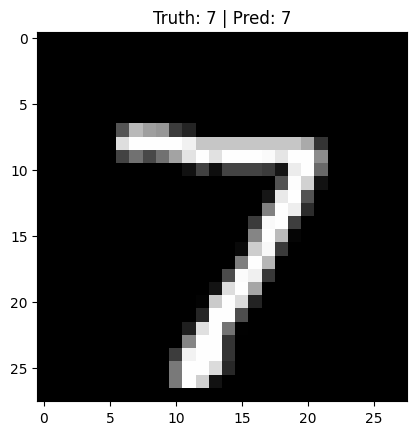

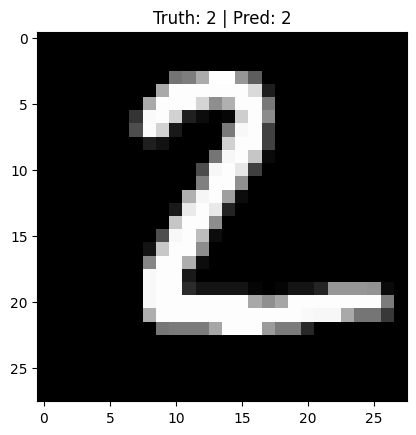

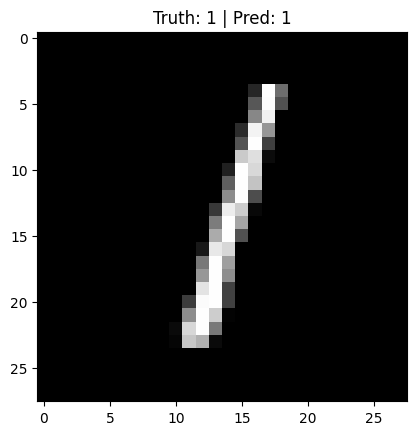

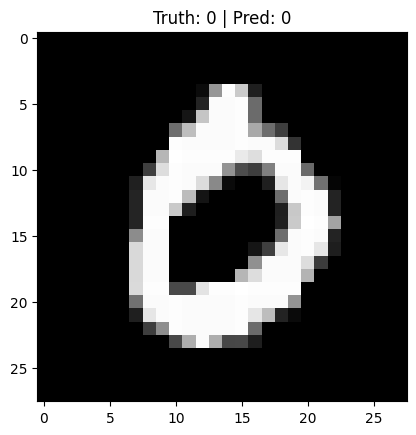

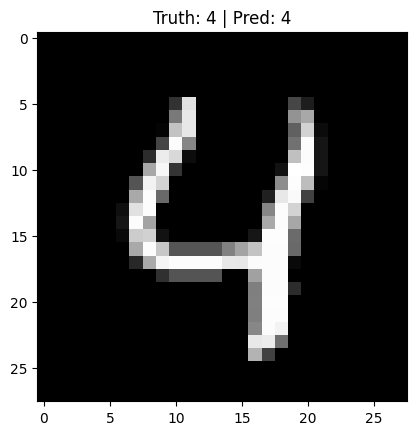

In [ ]:
# Plotting 5 plots also with true and predicted values
num_to_plot = 5
for i in range(num_to_plot):
  img = test_data[i][0]
  label = test_data[i][1]
  model_pred_logits = model_1_MNIST_GPU(img.unsqueeze(dim=0).to(device))
  model_pred_probs = torch.softmax(model_pred_logits, dim=1)
  model_pred_label = torch.argmax(model_pred_probs, dim=1)

  plt.figure()
  plt.imshow(img.squeeze(), cmap="gray")
  plt.title(f"Truth: {label} | Pred: { model_pred_label.cpu().item()}")
  plt.axis();



In [ ]:
total_time_model_1_GPU

40.00385599900028

## GPU trained FashionMNIST

In [ ]:
# Setting model for FashionMNIST dataset trained on GPU device
model_1_fashion_GPU = FashionMNISTmodel(input_shape=1,
                                        hidden_units=10,
                                        output_shape=len(class_names)).to(device)

In [ ]:
# Setting optimizer
optimizer_gpu_fashion = torch.optim.SGD(model_1_fashion_GPU.parameters(), lr=0.1)

In [ ]:
### Training FashionMNIST model on FashioMNIST dataset using GPU device
### and also with train/test step functions

# Setting manual seed
torch.manual_seed(42)

# Setting number of epochs
epochs = 3

# Timestamping start of the loop
train_time_start_gpu = timer()

# Training and testing loop using train/test step functions
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}")

  # Calling the training step function with necessary inputs
  train_step(model=model_1_fashion_GPU,
             loss_fn=loss_fn,
             optimizer=optimizer_gpu_fashion,
             data_loader=fashion_train_dataloader,
             accuracy_fn=accuracy_fn,
             device=device)

  # Calling the test step function with necessary inputs
  test_step(model=model_1_fashion_GPU,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            data_loader=fashion_test_dataloader,
            device=device)

# Timestamping end of the loop for further calculations
train_time_end_gpu = timer()

# Calculating ovarall time needed for training the model
total_time_model_1_GPU_fashion = train_time_end_gpu - train_time_start_gpu

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.58571 | Train acc: 73.19333333333333%
Test loss: 0.40417 | Test acc: 77.77%
Epoch: 1
Train loss: 0.36538 | Train acc: 78.42166666666667%
Test loss: 0.36181 | Test acc: 78.99%
Epoch: 2
Train loss: 0.32864 | Train acc: 79.61833333333334%
Test loss: 0.32731 | Test acc: 79.32%


In [ ]:
total_time_model_1_GPU_fashion

38.84763823399999

In [ ]:
# Getting final data for plotting barh plot
final_data = {
    "MNIST_Model_CPU":total_time_model_0_cpu,
    "MNIST_Model_GPU": total_time_model_1_GPU,
    "FashionMNIST_Model_CPU": time_model_0_fashion_cpu_end,
    "FashionMNIST_Model_GPU": total_time_model_1_GPU_fashion
}

Text(0.5, 1.0, "ALL models' time GPU and CPU")

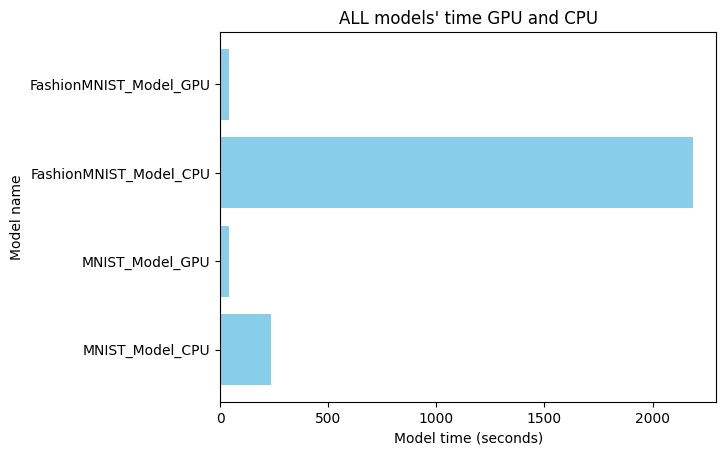

In [ ]:
# Plotting barh plot for models' train time comparisons
model_name = list(final_data.keys())
model_time = list(final_data.values())

plt.barh(model_name, model_time, color="skyblue")
plt.xlabel("Model time (seconds)")
plt.ylabel("Model name")
plt.title("ALL models' time GPU and CPU")